# Explanations from $MaxSim$

In [1]:
from tqdm.notebook import tqdm
from colbert.data import Queries, Collection
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import maxsime

sns.set_theme(style="whitegrid")

In [2]:
from importlib import reload
reload(maxsime)

MaxSimE = maxsime.MaxSimE
align_explanations = maxsime.align_explanations
fidelity = maxsime.fidelity
evaluate = maxsime.evaluate
visualize_correlation = maxsime.visualize_correlation
visualize_match = maxsime.visualize_match

<br/>

### Load collection and queries

In [3]:
collection = Collection(path=str(MaxSimE.dataroot / MaxSimE.dataset / MaxSimE.datasplit / 'collection.tsv'))
queries = Queries(path=str(MaxSimE.dataroot / MaxSimE.dataset / MaxSimE.datasplit / 'questions.search.tsv'))

f'Loaded {len(queries)} queries and {len(collection):,} passages'

[Feb 15, 18:12:46] #> Loading collection...
0M 1M 2M 
[Feb 15, 18:12:53] #> Loading the queries from /home/IAIS/hiser/data/LOTTE/pooled/dev/questions.search.tsv ...
[Feb 15, 18:12:53] #> Got 2931 queries. All QIDs are unique.



'Loaded 2931 queries and 2,428,854 passages'

<br/>

### **LoTTE** full retrieval and fidelity evaluation

In [4]:
colbert = MaxSimE(collection=collection, model="colbert")
rankings = colbert.searcher.search_all(queries, k=5).todict()

[Feb 15, 18:12:53] #> Loading collection...
0M 1M 2M 
[Feb 15, 18:13:04] #> Loading codec...
[Feb 15, 18:13:04] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Feb 15, 18:13:04] Loading packbits_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Feb 15, 18:13:04] #> Loading IVF...
[Feb 15, 18:13:05] #> Loading doclens...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 856.35it/s]


[Feb 15, 18:13:05] #> Loading codes and residuals...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2931/2931 [00:23<00:00, 124.25it/s]


<br/>

## Analysing explanations

In [5]:
df = pd.read_json(MaxSimE.dataroot / MaxSimE.dataset / MaxSimE.datasplit / 'qas.search.jsonl', lines=True).set_index("qid")
df_pred = pd.DataFrame.from_dict({k: [*zip(*v)] for k, v in rankings.items()}, orient="index", columns=["prediction_pids", "rank", "similarity"]).drop(columns="rank")

df = df.join(df_pred)
df["hits"] = df[["answer_pids", "prediction_pids"]].apply(lambda row: list(set(row[0]) & set(row[1])), axis=1)

df

,query,url,answer_pids,prediction_pids,similarity,hits
qid,,,,,,
0,how are you doing lately meaning?,https://ell.stackexchange.com/questions/20134/...,[9032],"(41780, 14612, 3449, 77013, 44093)","(22.3125, 21.125, 20.859375, 20.65625, 20.4375)",[]
1,what is the difference between people's and pe...,https://ell.stackexchange.com/questions/96287/...,"[39506, 39507]","(39506, 39507, 26396, 60137, 5071)","(24.21875, 23.296875, 22.5625, 22.3125, 22.015...","[39506, 39507]"
2,what to answer when someone says you are the b...,https://ell.stackexchange.com/questions/10517/...,"[4893, 4895, 4912]","(33377, 759934, 88914, 788450, 98741)","(24.1875, 22.328125, 21.296875, 21.15625, 20.9...",[]
3,what is the difference of location and position?,https://ell.stackexchange.com/questions/76456/...,"[31507, 90314]","(31507, 3818, 94569, 90314, 3810)","(25.09375, 24.765625, 23.265625, 22.78125, 22....","[90314, 31507]"
4,has hair or have hair?,https://ell.stackexchange.com/questions/72428/...,"[29672, 29678, 29691]","(154294, 61269, 62118, 25607, 79311)","(21.3125, 21.140625, 20.0625, 18.96875, 18.890...",[]
...,...,...,...,...,...,...
2926,is there a fuse for airbags?,https://mechanics.stackexchange.com/questions/...,"[2411979, 2411980, 2411982, 2411987, 2411988, ...","(2411988, 2403039, 2414038, 2408195, 2413642)","(26.1875, 25.453125, 25.3125, 23.703125, 23.01...","[2413642, 2411988]"
2927,what last longer manual or automatic transmiss...,https://mechanics.stackexchange.com/questions/...,"[2404563, 2408399, 2412073]","(2408399, 2404563, 2412073, 2423657, 2411857)","(24.96875, 22.40625, 21.546875, 21.453125, 20.5)","[2412073, 2404563, 2408399]"
2928,how much does it cost to replace a scion tc en...,https://mechanics.stackexchange.com/questions/...,[2416435],"(2403493, 2404559, 891670, 500989, 919228)","(18.078125, 17.34375, 16.6875, 16.515625, 16.4...",[]


In [6]:
queries = queries
documents = [collection[df.loc[q_id]["prediction_pids"][0]] for q_id in df.index]

In [17]:
bert_base = MaxSimE(collection=collection, model_type="bi-encoder", model="msmarco-bert-base-dot-v5")
non_colbert = bert_base
# tiny_bert = MaxSimE(collection=collection, model_type="cross-encoder", model="cross-encoder/ms-marco-TinyBERT-L-2-v2")
# non_colbert = tiny_bert

Why do kittens love packets? 

Cats enjoy boxes because they love hiding places. When they are inside a box they are covered on all sides but one. Which means they are safe and can keep an eye out on the one open side. Boxes also allow for the cats to quickly dart from the box if something of interest appears, and allows for a quick retreat if necessary. 



,doc_token_1,ColBERTv2,doc_token_2,S-BERT$_{base}$
Top 8 ranked query tokens,,,,
[CLS],[CLS],0.728127,[CLS],0.843375
why,because,0.874219,because,0.911223
do,which,0.721722,to,0.847687
kitten,[D],0.809041,cats,0.891421
##s,they,0.756199,they,0.874169
love,love,0.693756,love,0.911951
packets,boxes,0.484977,dart,0.787479
?,boxes,0.465596,means,0.843207


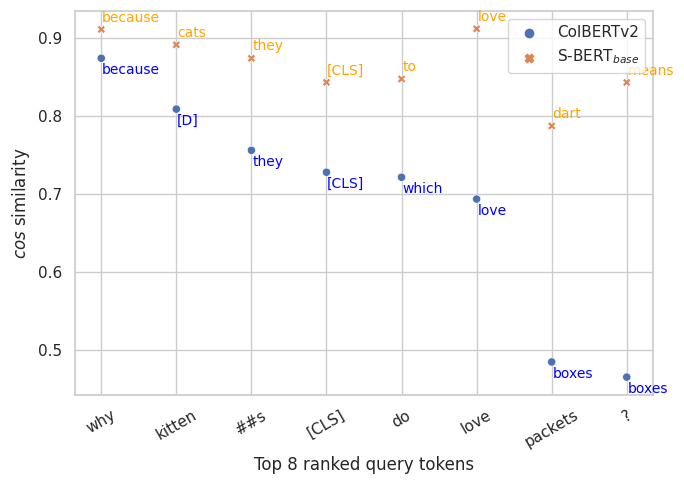

In [19]:
q_id = 3
doc_idx = 0

# query = queries[q_id]
# doc = collection[df.loc[q_id]["prediction_pids"][doc_idx]]

query = "Why do kittens love packets?"
doc = "Cats enjoy boxes because they love hiding places. When they are inside a box they are covered on all sides but one. Which means they are safe and can keep an eye out on the one open side. Boxes also allow for the cats to quickly dart from the box if something of interest appears, and allows for a quick retreat if necessary."

print(query, "\n")
print(doc, "\n")

expl = align_explanations(colbert.explain_match(query, doc)[-1], non_colbert.explain_match(query, doc)[-1])
expl.index.names = ["Top 8 ranked query tokens"]
expl = expl.rename(columns={
    "score_1": "ColBERTv2",
    "score_2": "S-BERT$_{base}$"
})

plt.figure(figsize=(7, 5), tight_layout=True)
visualize_correlation(expl, labelsize='small', labelweight=None, col_names=["ColBERTv2", "S-BERT$_{base}$"], rotate_xticks=30)
plt.savefig("plots/scatterplot.pdf")
expl

In [11]:
def gather_rankings(mxsm1, mxsm2, queries, documents, n=8):
    df = None
    for query, doc in tqdm(zip(queries, documents), total=len(queries)):
        df_new = align_explanations(colbert.explain_match(query[1], doc)[-1], non_colbert.explain_match(query[1], doc)[-1])
        df_new = df_new.sort_values(by=["score_1", "score_2"], ascending=False).reset_index()[["score_1", "score_2"]].iloc[:n].T
        if df is None:
            df = df_new
        else:
            df = pd.concat([df, df_new])

    return df

df_rank = gather_rankings(colbert, non_colbert, queries, documents)
df_rank

  0%|          | 0/2931 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (927 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (929 > 512). Running this sequence through the model will result in indexing errors


,0,1,2,3,4,5,6,7
score_1,0.935129,0.721573,0.611205,0.363167,0.350045,0.337793,0.333961,0.210032
score_2,0.916420,0.892926,0.891134,0.885172,0.909303,0.932369,0.857312,0.905889
score_1,0.930236,0.712399,0.701016,0.676625,0.638544,0.627558,0.587822,0.508395
score_2,0.929220,0.927083,0.913395,0.923601,0.910372,0.917827,0.846038,0.933968
score_1,0.940412,0.889126,0.877763,0.719085,0.680754,0.626835,0.531165,0.529162
...,...,...,...,...,...,...,...,...
score_2,0.849753,0.852688,0.799722,0.840345,0.873656,0.926583,0.782977,0.824382
score_1,0.921301,0.921226,0.866711,0.751851,0.638097,0.623259,0.526945,0.389915
score_2,0.913036,0.920491,0.835982,0.885347,0.902818,0.889394,0.902773,0.928244
score_1,0.961458,0.954546,0.911690,0.894765,0.888628,0.814521,0.654131,0.612976


In [14]:
df_plot = df_rank.reset_index().melt('index').rename(columns={"variable": "Top 8 ranked query tokens", "value": "$cos$ similarity", "index": "Model"})
d = {
    "score_1": "ColBERTv2",
    "score_2": "S-BERT$_{base}$"
}
df_plot["Model"] = df_plot["Model"].apply(lambda m: d[m])
df_plot["Top 8 ranked query tokens"] = df_plot["Top 8 ranked query tokens"].astype("int")
df_plot["$cos$ similarity"] = df_plot["$cos$ similarity"].astype("float")

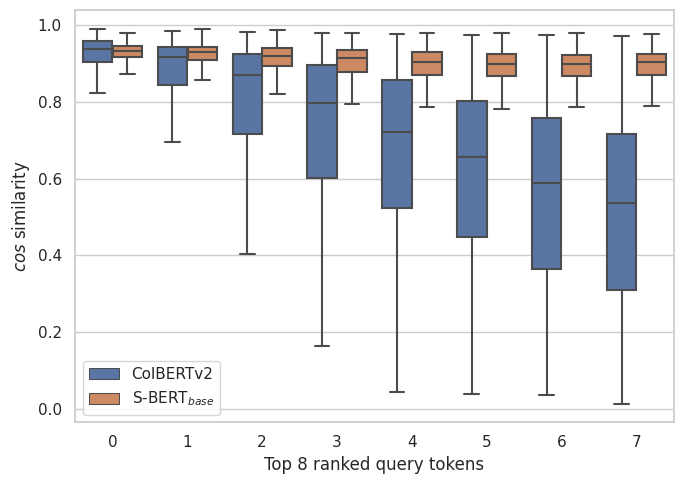

In [15]:
plt.figure(figsize=(7, 5), tight_layout=True)
scp = sns.boxplot(df_plot, x="Top 8 ranked query tokens", y="$cos$ similarity", hue="Model", fliersize=False)
plt.legend(loc='lower left')
plt.savefig("plots/boxplot.pdf");

<br/>

## Evaluating model fidelity

In [20]:
queries = queries
documents = [collection[df.loc[q_id]["prediction_pids"][0]] for q_id in df.index]

In [21]:
bert_base = MaxSimE(collection=collection, model_type="bi-encoder", model="msmarco-bert-base-dot-v5")
distilbert = MaxSimE(collection=collection, model_type="bi-encoder", model="msmarco-distilbert-dot-v5")
mini_lm_bi = MaxSimE(collection=collection, model_type="bi-encoder", model="msmarco-MiniLM-L6-cos-v5")

tiny_bert = MaxSimE(collection=collection, model_type="cross-encoder", model="cross-encoder/ms-marco-TinyBERT-L-2-v2")
mini_lm = MaxSimE(collection=collection, model_type="cross-encoder", model="cross-encoder/ms-marco-MiniLM-L-6-v2")

In [22]:
tp, ma, sr, ps = evaluate(colbert, bert_base, queries, documents)
print("msmarco-bert-base-dot-v5")
print(f"token precision {tp.mean():.3f} ± {tp.std():.3f}")
print(f"match accuracy  {ma.mean():.3f} ± {ma.std():.3f}")
print(f"spearman rank   {sr.mean():.3f} ± {sr.std():.3f}")
print(f"pearson correl. {ps.mean():.3f} ± {ps.std():.3f}")

  0%|          | 0/2931 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (929 > 512). Running this sequence through the model will result in indexing errors


msmarco-bert-base-dot-v5
token precision 0.730 ± 0.153
match accuracy  0.471 ± 0.213
spearman rank   0.427 ± 0.380
pearson correl. 0.400 ± 0.358


In [23]:
tp, ma, sr, ps = evaluate(colbert, distilbert, queries, documents)
print("msmarco-distilbert-dot-v5")
print(f"token precision {tp.mean():.3f} ± {tp.std():.3f}")
print(f"match accuracy  {ma.mean():.3f} ± {ma.std():.3f}")
print(f"spearman rank   {sr.mean():.3f} ± {sr.std():.3f}")
print(f"pearson correl. {ps.mean():.3f} ± {ps.std():.3f}")

  0%|          | 0/2931 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (929 > 512). Running this sequence through the model will result in indexing errors


msmarco-distilbert-dot-v5
token precision 0.740 ± 0.163
match accuracy  0.444 ± 0.212
spearman rank   0.349 ± 0.386
pearson correl. 0.333 ± 0.359


In [24]:
tp, ma, sr, ps = evaluate(colbert, mini_lm_bi, queries, documents)
print("msmarco-MiniLM-L6-cos-v5")
print(f"token precision {tp.mean():.3f} ± {tp.std():.3f}")
print(f"match accuracy  {ma.mean():.3f} ± {ma.std():.3f}")
print(f"spearman rank   {sr.mean():.3f} ± {sr.std():.3f}")
print(f"pearson correl. {ps.mean():.3f} ± {ps.std():.3f}")

  0%|          | 0/2931 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (929 > 512). Running this sequence through the model will result in indexing errors


msmarco-MiniLM-L6-cos-v5
token precision 0.664 ± 0.149
match accuracy  0.411 ± 0.200
spearman rank   0.473 ± 0.376
pearson correl. 0.476 ± 0.369


In [25]:
tp, ma, sr, ps = evaluate(colbert, tiny_bert, queries, documents)
print("cross-encoder/ms-marco-TinyBERT-L-2-v2")
print(f"token precision {tp.mean():.3f} ± {tp.std():.3f}")
print(f"match accuracy  {ma.mean():.3f} ± {ma.std():.3f}")
print(f"spearman rank   {sr.mean():.3f} ± {sr.std():.3f}")
print(f"pearson correl. {ps.mean():.3f} ± {ps.std():.3f}")

  0%|          | 0/2931 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (929 > 512). Running this sequence through the model will result in indexing errors


cross-encoder/ms-marco-TinyBERT-L-2-v2
token precision 0.749 ± 0.158
match accuracy  0.446 ± 0.204
spearman rank   0.391 ± 0.343
pearson correl. 0.364 ± 0.333


In [26]:
tp, ma, sr, ps = evaluate(colbert, mini_lm, queries, documents)
print("cross-encoder/ms-marco-MiniLM-L-6-v2")
print(f"token precision {tp.mean():.3f} ± {tp.std():.3f}")
print(f"match accuracy  {ma.mean():.3f} ± {ma.std():.3f}")
print(f"spearman rank   {sr.mean():.3f} ± {sr.std():.3f}")
print(f"pearson correl. {ps.mean():.3f} ± {ps.std():.3f}")

  0%|          | 0/2931 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (929 > 512). Running this sequence through the model will result in indexing errors


cross-encoder/ms-marco-MiniLM-L-6-v2
token precision 0.387 ± 0.233
match accuracy  0.307 ± 0.192
spearman rank   0.270 ± 0.284
pearson correl. 0.217 ± 0.255


<br/>

## TODOs

- Situation mit [MASK] tokens beschreiben (Ranking mit MASK, aber ausgeblendet wegen Blackbox); Anteil am ranking score von MASK tokens - Hängt von padding ab? -> Kürzere Queries ranking hängt mehr von masks ab
- Spearman Rank / Token Precision / Matching precision für verschiedene Modelle berechnen
- Scatterplot mit tokens

In [28]:
queries = queries
documents = [collection[df.loc[q_id]["prediction_pids"][doc_idx]] for q_id in df.index]

In [29]:
score_unmask, score_mask = [], []
for query, doc in tqdm(zip(queries, documents), total=len(queries)):
    scores, similarity, _, _ = colbert.explain_match(query[1], doc)
    score_unmask.append(scores.max(-1)[0].sum())
    score_mask.append(similarity)

score_unmask = torch.Tensor(score_unmask)
score_mask = torch.Tensor(score_mask)

mask_percentage = (1 - score_unmask / score_mask).mean()
mask_percentage

  0%|          | 0/2931 [00:00<?, ?it/s]

tensor(0.6898)

<br/>

## Visualizing the correlation matrix

In [27]:
query = "Why do kittens love packets?"
doc = "Cats enjoy boxes because they love hiding places. When they are inside a box they are covered on all sides but one. Which means they are safe and can keep an eye out on the one open side. Boxes also allow for the cats to quickly dart from the box if something of interest appears, and allows for a quick retreat if necessary."

print(query, "\n")
print(doc, "\n")

# _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True, sharey=True)
# visualize_match(*colbert.explain_match(query, doc), ax=ax1)
# visualize_match(*non_colbert.explain_match(query, doc), ax=ax2)
df_expl = align_explanations(colbert.explain_match(query, doc)[-1], non_colbert.explain_match(query, doc)[-1]).round(3)
df_expl = df_expl.sort_values(by=["score_1", "score_2"], ascending=False)
df_expl.to_csv("plots/explanation.csv", sep=";")
df_expl

Why do kittens love packets? 

Cats enjoy boxes because they love hiding places. When they are inside a box they are covered on all sides but one. Which means they are safe and can keep an eye out on the one open side. Boxes also allow for the cats to quickly dart from the box if something of interest appears, and allows for a quick retreat if necessary. 



,doc_token_1,score_1,doc_token_2,score_2
query_token,,,,
why,because,0.874,because,0.911
kitten,[D],0.809,cats,0.891
##s,they,0.756,they,0.874
[CLS],[CLS],0.728,[CLS],0.843
do,which,0.722,to,0.848
love,love,0.694,love,0.912
packets,boxes,0.485,dart,0.787
?,boxes,0.466,means,0.843


how are you doing lately meaning? 

If it weren't for the word lately, the choice would simply depend on what exactly we've noticed. For simplicity we'll ignore the negation and suppose we noticed one of... 1: you have been doing it you were doing it before, and you're still doing it now 2: you are doing it you're doing it now, but maybe you weren't before 3: you were doing it you were doing it before, but maybe you're not doing it now 4: you had been doing it you were doing it before, but [probably] you're not still doing it now But lately implies from some [relatively recent] time in the past up to and including the present, which means that only #1 works really well. The others are at least "credible" (though #4 seems rather strange to me - why introduce such a complex verb form when there's nothing that definitely needs to be identified as having happened before something else?). 

It can be interpreted literally or figuratively. Literally it means "what activities have you partici

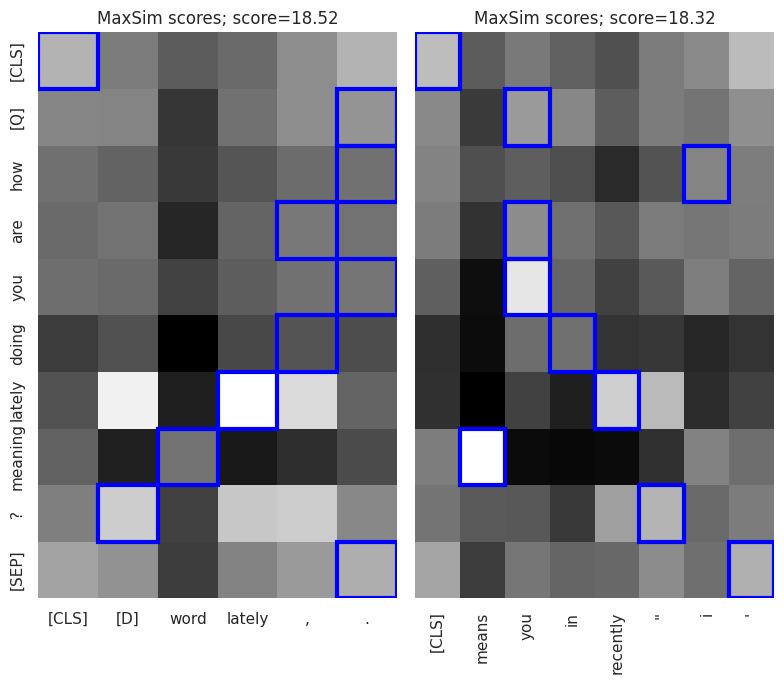

In [24]:
q_id = 0
doc_idx = 0

query = queries[q_id]
doc = collection[df.loc[q_id]["prediction_pids"][doc_idx]]
doc_true = collection[df.loc[q_id]["answer_pids"][doc_idx]]

print(query, "\n")
print(doc, "\n")
print(doc_true, "\n")

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 7), tight_layout=True, sharey=True)
visualize_match(*colbert.explain_match(query, doc), ax=ax1)
visualize_match(*colbert.explain_match(query, doc_true), ax=ax2)

how are you doing lately meaning? 

If it weren't for the word lately, the choice would simply depend on what exactly we've noticed. For simplicity we'll ignore the negation and suppose we noticed one of... 1: you have been doing it you were doing it before, and you're still doing it now 2: you are doing it you're doing it now, but maybe you weren't before 3: you were doing it you were doing it before, but maybe you're not doing it now 4: you had been doing it you were doing it before, but [probably] you're not still doing it now But lately implies from some [relatively recent] time in the past up to and including the present, which means that only #1 works really well. The others are at least "credible" (though #4 seems rather strange to me - why introduce such a complex verb form when there's nothing that definitely needs to be identified as having happened before something else?). 

It can be interpreted literally or figuratively. Literally it means "what activities have you partici

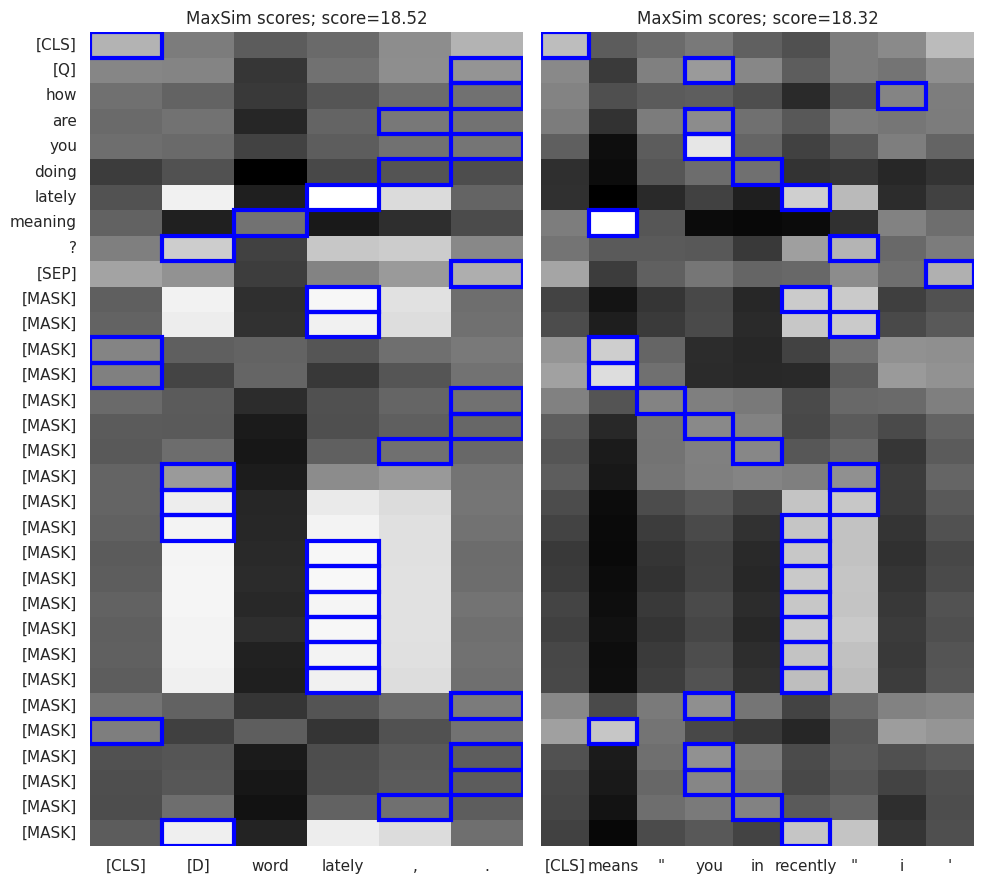

In [25]:
q_id = 0
doc_idx = 0

query = queries[q_id]
doc = collection[df.loc[q_id]["prediction_pids"][doc_idx]]
doc_true = collection[df.loc[q_id]["answer_pids"][doc_idx]]

print(query, "\n")
print(doc, "\n")
print(doc_true, "\n")

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 9), tight_layout=True, sharey=True)
visualize_match(*colbert.explain_match(query, doc, strip_mask=False), ax=ax1)
visualize_match(*colbert.explain_match(query, doc_true, strip_mask=False), ax=ax2)

Why do kittens love packets? 

Cats enjoy boxes because they love hiding places. When they are inside a box they are covered on all sides but one. Which means they are safe and can keep an eye out on the one open side. Boxes also allow for the cats to quickly dart from the box if something of interest appears, and allows for a quick retreat if necessary. 



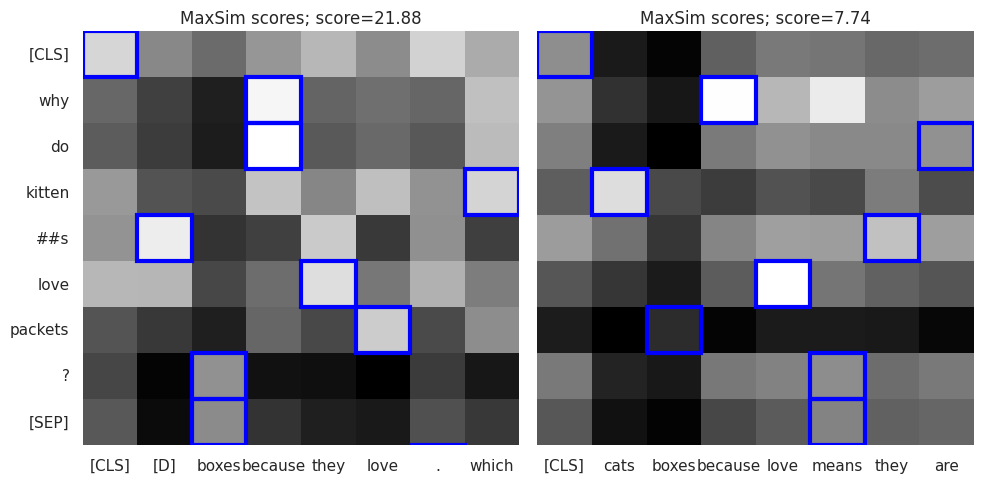

In [26]:
query = "Why do kittens love packets?"
doc = "Cats enjoy boxes because they love hiding places. When they are inside a box they are covered on all sides but one. Which means they are safe and can keep an eye out on the one open side. Boxes also allow for the cats to quickly dart from the box if something of interest appears, and allows for a quick retreat if necessary."

print(query, "\n")
print(doc, "\n")

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True, sharey=True)
visualize_match(*colbert.explain_match(query, doc), ax=ax1)
visualize_match(*non_colbert.explain_match(query, doc), ax=ax2)

what is the difference of location and position? 

Location definitely doesn't include orientation, but position could, but doesn't always. Location always refers to a place, and can sometimes be used more specifically to where you are inside a place, but no more. Position usually starts with layout, like stretching or yoga positions for one person, or your position on a team for multiple people. That type of position refers to your place as part of a team, and can also be used for the role you play or your job title in an office. Finally, position can be used in the same sense as location, where you are within a place. Position could include orientation for both the one person meaning and the location within a place, but it can't be assumed that it does. Really, you should just use orientation as well when you need to be specific about including that. 



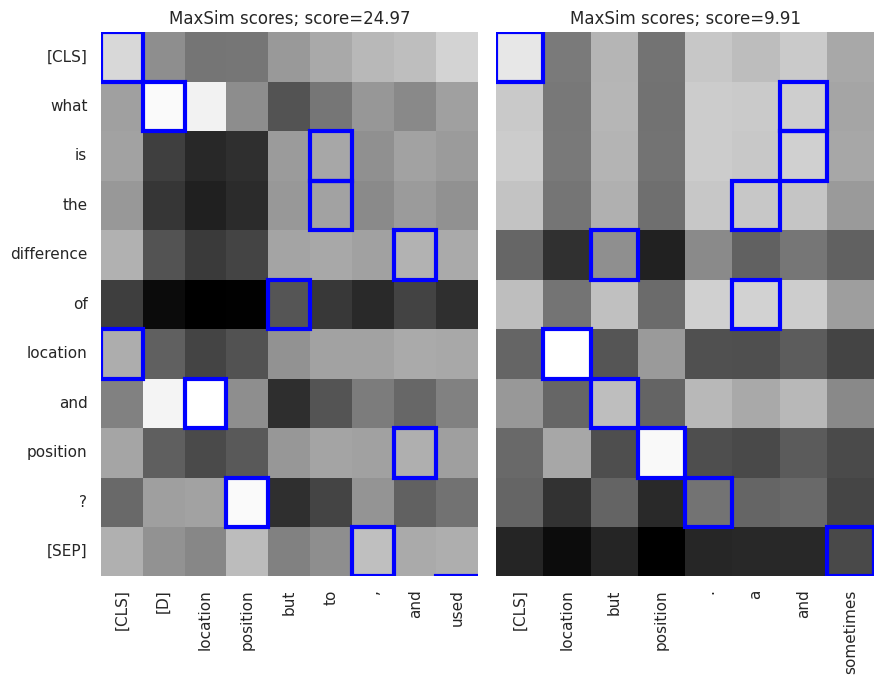

In [27]:
q_id = 3
doc_idx = 0

query = queries[q_id]
doc = collection[df.loc[q_id]["prediction_pids"][doc_idx]]

print(query, "\n")
print(doc, "\n")

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 7), tight_layout=True, sharey=True)
visualize_match(*colbert.explain_match(query, doc), ax=ax1)
visualize_match(*non_colbert.explain_match(query, doc), ax=ax2)

what is the difference of location and position? 

Location definitely doesn't include orientation, but position could, but doesn't always. Location always refers to a place, and can sometimes be used more specifically to where you are inside a place, but no more. Position usually starts with layout, like stretching or yoga positions for one person, or your position on a team for multiple people. That type of position refers to your place as part of a team, and can also be used for the role you play or your job title in an office. Finally, position can be used in the same sense as location, where you are within a place. Position could include orientation for both the one person meaning and the location within a place, but it can't be assumed that it does. Really, you should just use orientation as well when you need to be specific about including that. 



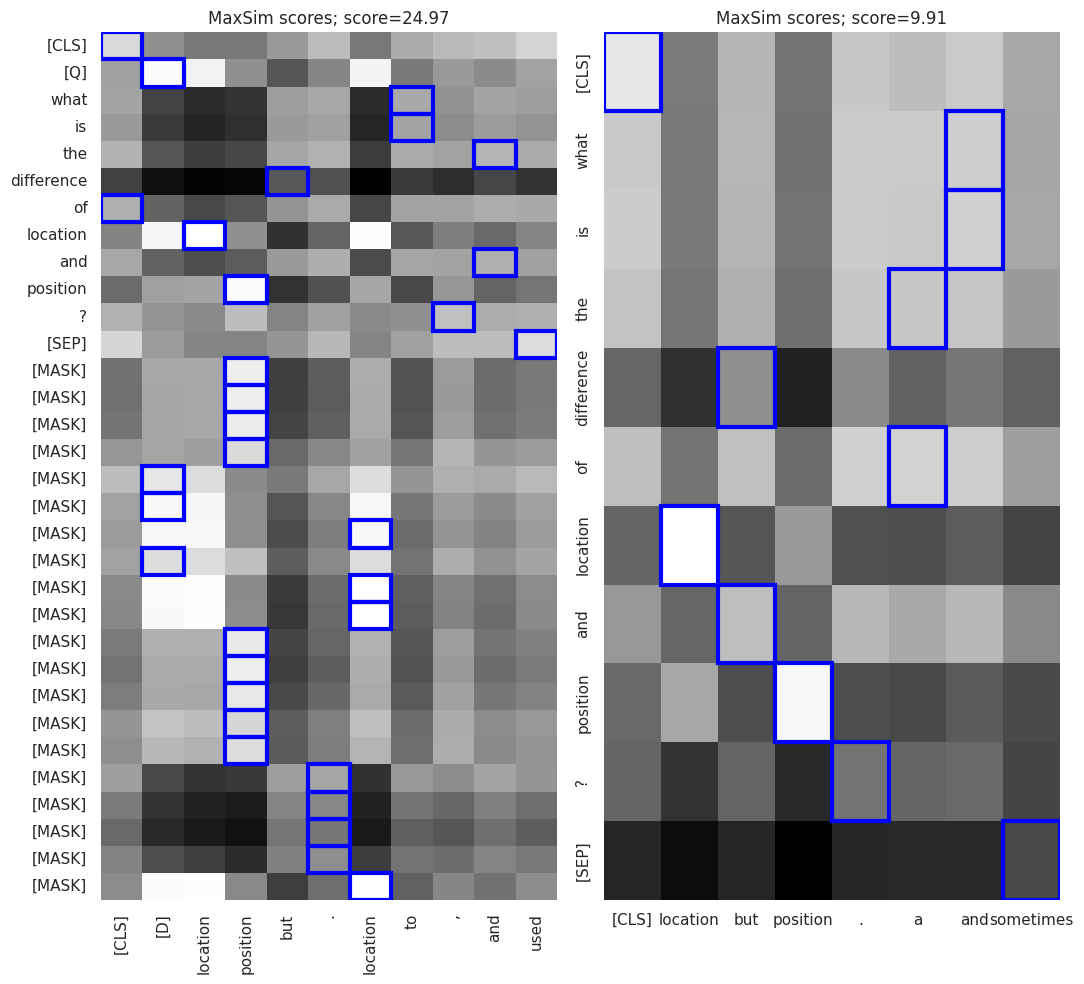

In [28]:
q_id = 3
doc_idx = 0

query = queries[q_id]
doc = collection[df.loc[q_id]["prediction_pids"][doc_idx]]

print(query, "\n")
print(doc, "\n")

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 10), tight_layout=True, sharey=False)
visualize_match(*colbert.explain_match(query, doc, strip_mask=False), ax=ax1)
visualize_match(*non_colbert.explain_match(query, doc, strip_mask=False), ax=ax2)